# Load Library & Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
import seaborn as sns
style.use("fivethirtyeight")

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission_sample.csv')

# correlation 파악하기

<AxesSubplot:>

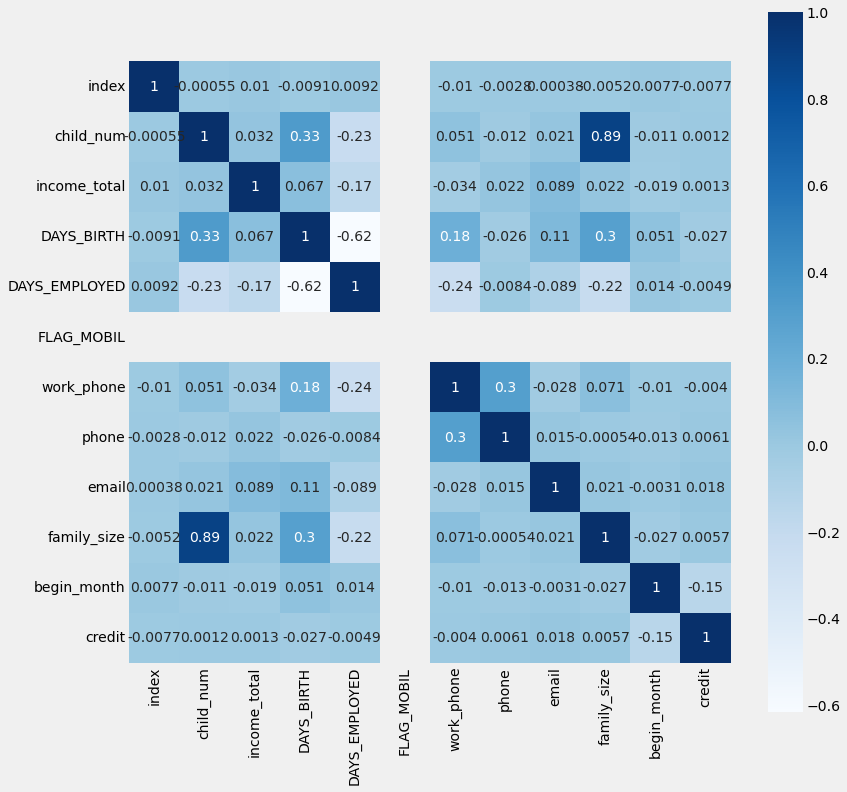

In [4]:
# 전체 히트맵
plt.figure(figsize = (12,12))
sns.heatmap(train.corr(),square = True, annot = True, cmap='Blues')

In [5]:
corr_df = train.corr()
corr_df = corr_df.apply(lambda x: round(x ,2))

In [6]:
s = corr_df.unstack()
df = pd.DataFrame(s[s < 1].sort_values(ascending=False), columns=['corr'])
df.style.background_gradient(cmap='viridis')

+ child_num과 family_size는 0.89로 양의 상관관계가 매우 뚜렷이 나타남.

# credit 분석

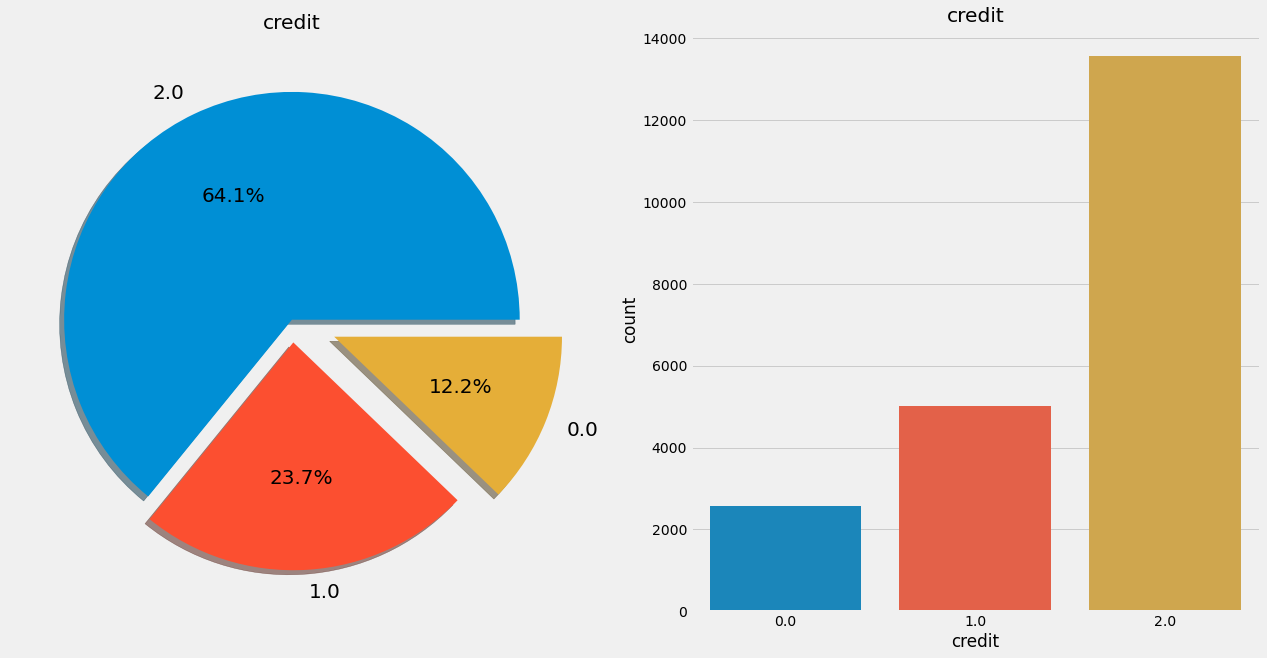

In [7]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

train['credit'].value_counts().plot.pie(explode=[0, 0.1, 0.2],
                                         autopct='%1.1f%%',
                                         ax=ax[0],
                                         shadow=True,
                                         fontsize=20)
ax[0].set_title('credit')
ax[0].set_ylabel('')

sns.countplot('credit', data=train, ax=ax[1])
ax[1].set_title('credit')
plt.show()

- 신용도가 높은 순서대로 12%, 24%, 64%의 비율

# 숫자형 변수 전처리

## 파생변수(ability, before_EMPLOYED)

In [8]:
#ability: 소득/(살아온 일수+ 근무일수)
train['ability'] = train['income_total'] / (train['DAYS_BIRTH'] + train['DAYS_EMPLOYED'])
test['ability'] = test['income_total'] / (test['DAYS_BIRTH'] + test['DAYS_EMPLOYED'])

# before_EMPLOYED: 고용되기 전까지의 일수
train['before_EMPLOYED'] = train['DAYS_BIRTH'] - train['DAYS_EMPLOYED']
test['before_EMPLOYED'] = test['DAYS_BIRTH'] - test['DAYS_EMPLOYED']

## DAYS_EMPLOYED

+ DAYS_EMPLOYED(업무시작일)에서 양수 값은 고용되지 않은 상태를 의미함
+ 따라서 모든 양수값을 0으로 바꿔야 함.

In [9]:
# day를 year로 변경해주는 함수
def days_to_year(x):
    return x/365

In [10]:
# 0 이상인 경우 0으로 모두 변환
train.loc[train['DAYS_EMPLOYED'] >= 0,'DAYS_EMPLOYED']=0
test.loc[test['DAYS_EMPLOYED'] >= 0,'DAYS_EMPLOYED']=0

# day를 year로 변환, 음수깂으로 나오므로 (-1) 곱해서 양수로 바꿔줌.
train['DAYS_EMPLOYED'] = days_to_year(train['DAYS_EMPLOYED'])*(-1)
test['DAYS_EMPLOYED'] = days_to_year(test['DAYS_EMPLOYED'])*(-1)

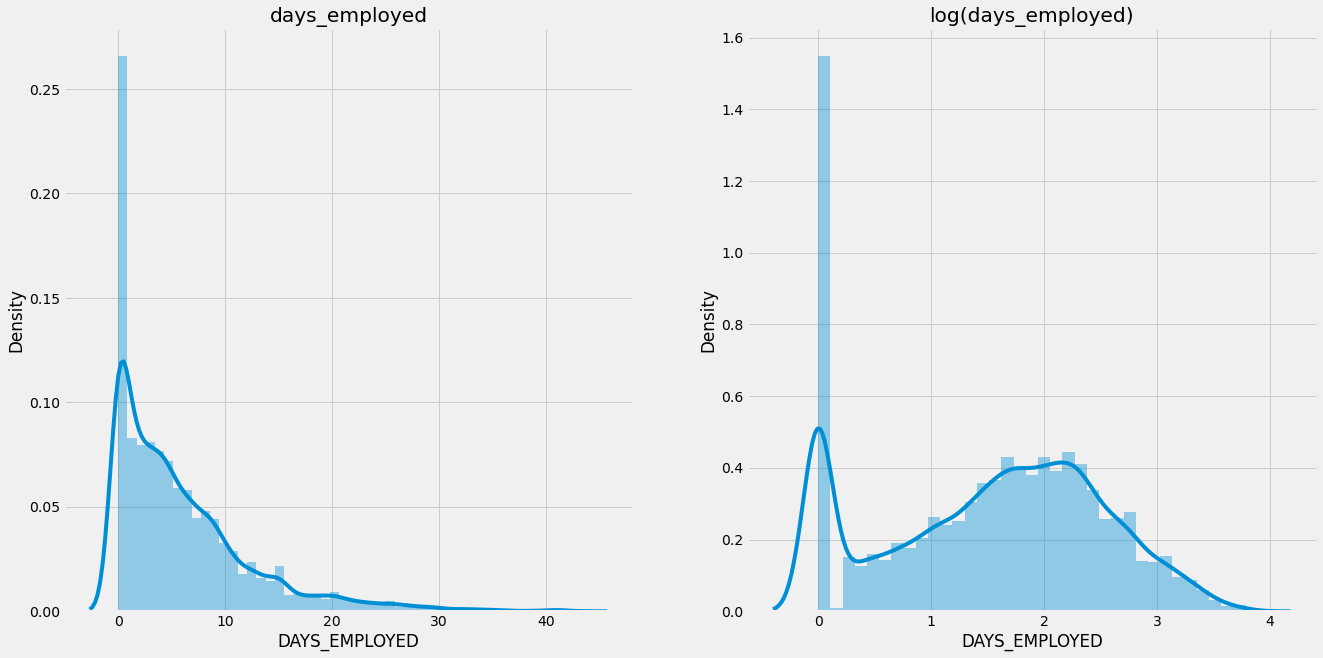

In [11]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.distplot(train['DAYS_EMPLOYED'],ax=ax[0])
ax[0].set_title('days_employed')

sns.distplot(np.log1p(train['DAYS_EMPLOYED']),ax=ax[1])
ax[1].set_title('log(days_employed)')
plt.show()

In [12]:
# 로그 변환
train['DAYS_EMPLOYED_log'] = train['DAYS_EMPLOYED'].apply(np.log1p)
test['DAYS_EMPLOYED_log'] = test['DAYS_EMPLOYED'].apply(np.log1p)

## income_total

+ income_total(연간소득)
+ 만원 단위로 만들자!

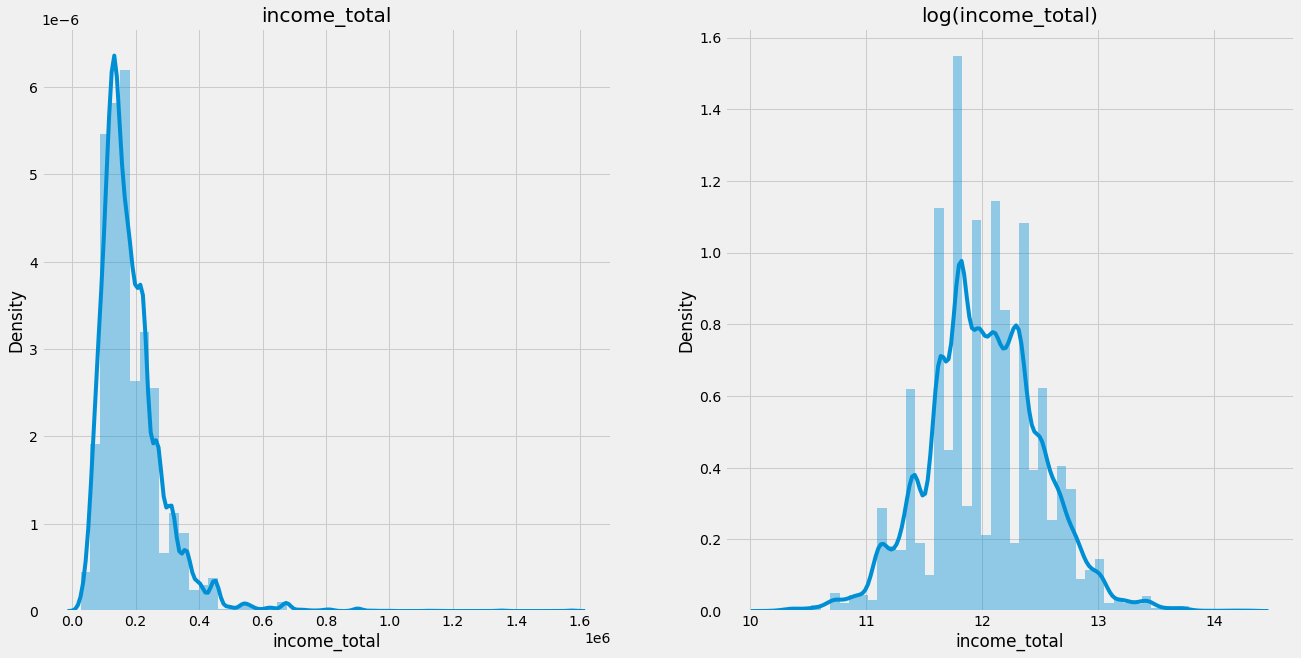

In [13]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.distplot(train['income_total'],ax=ax[0])
ax[0].set_title('income_total')

sns.distplot(np.log1p(train['income_total']),ax=ax[1])
ax[1].set_title('log(income_total)')
plt.show()

In [14]:
# 숫자가 너무 커 만단위로 바꿔줌.
train['income_total'] = train['income_total']/10000
test['income_total'] = test['income_total']/10000

# 편차 제곱 변수 생성
train['income_total_dev'] = (train['income_total'] - train['income_total'].mean())**2
test['income_total_dev'] = (test['income_total'] - test['income_total'].mean())**2

# 로그 변환
train['income_total_log'] = train['income_total'].apply(np.log1p)
test['income_total_log'] = test['income_total'].apply(np.log1p)

## DAYS_BIRTH

+ DAYS_BIRTH(출생일): 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미

In [15]:
# day를 year로 변환, 음수값으로 나타나므로 양수로 변환
train['DAYS_BIRTH'] = days_to_year(train['DAYS_BIRTH'])*(-1)
test['DAYS_BIRTH'] = days_to_year(test['DAYS_BIRTH'])*(-1)

In [16]:
min(train['DAYS_BIRTH'].unique())

21.10958904109589

In [17]:
max(train['DAYS_BIRTH'].unique())

68.90958904109588

In [18]:
#n개의 구간으로 나누기
n=10 #현재 10개로 설정
name=[int(i) for i in range(n)]
train['DAYS_BIRTH']=pd.cut(train['DAYS_BIRTH'],n,labels=name)
test['DAYS_BIRTH']=pd.cut(test['DAYS_BIRTH'],n,labels=name)

In [19]:
train['DAYS_BIRTH']=pd.to_numeric(train['DAYS_BIRTH'])
test['DAYS_BIRTH']=pd.to_numeric(test['DAYS_BIRTH'])

<AxesSubplot:xlabel='DAYS_BIRTH', ylabel='Density'>

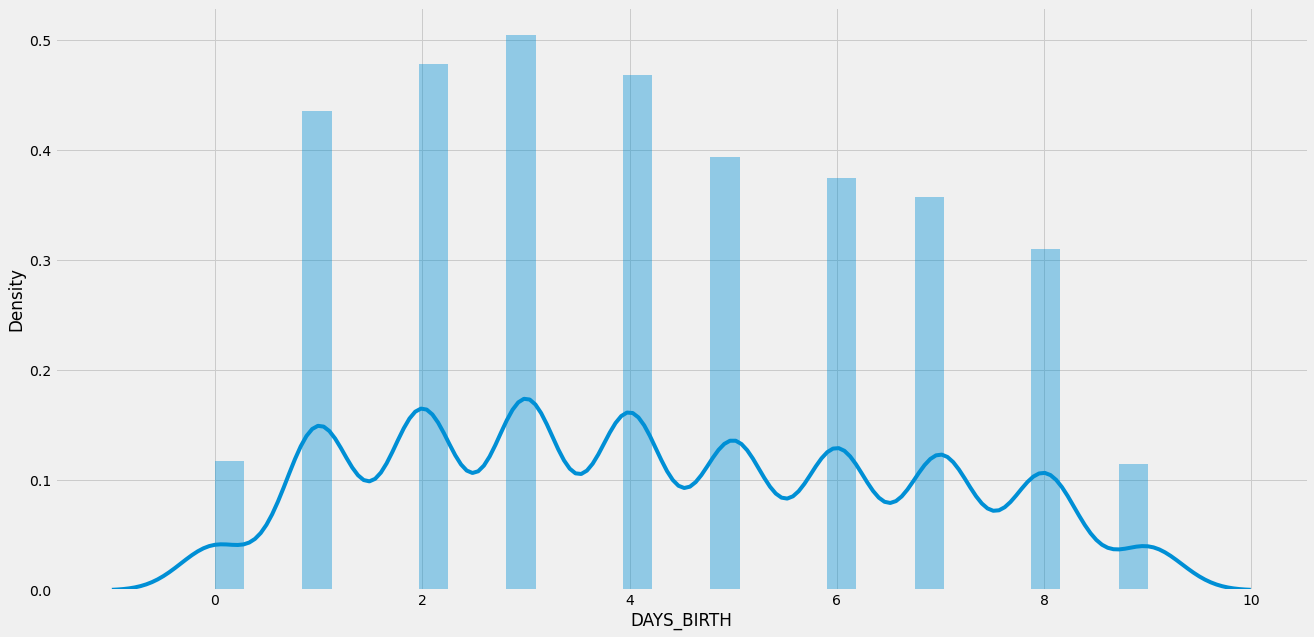

In [20]:
f, ax = plt.subplots(figsize=(20, 10))
sns.distplot(train['DAYS_BIRTH'])

## begin_month 전처리

+ begin_month(신용카드 발급 월): 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미

In [21]:
# 음수값으로 나타나므로 양수값으로 바꿈
train['begin_month'] = train['begin_month']*(-1)
test['begin_month'] = test['begin_month']*(-1)

<AxesSubplot:xlabel='begin_month', ylabel='Density'>

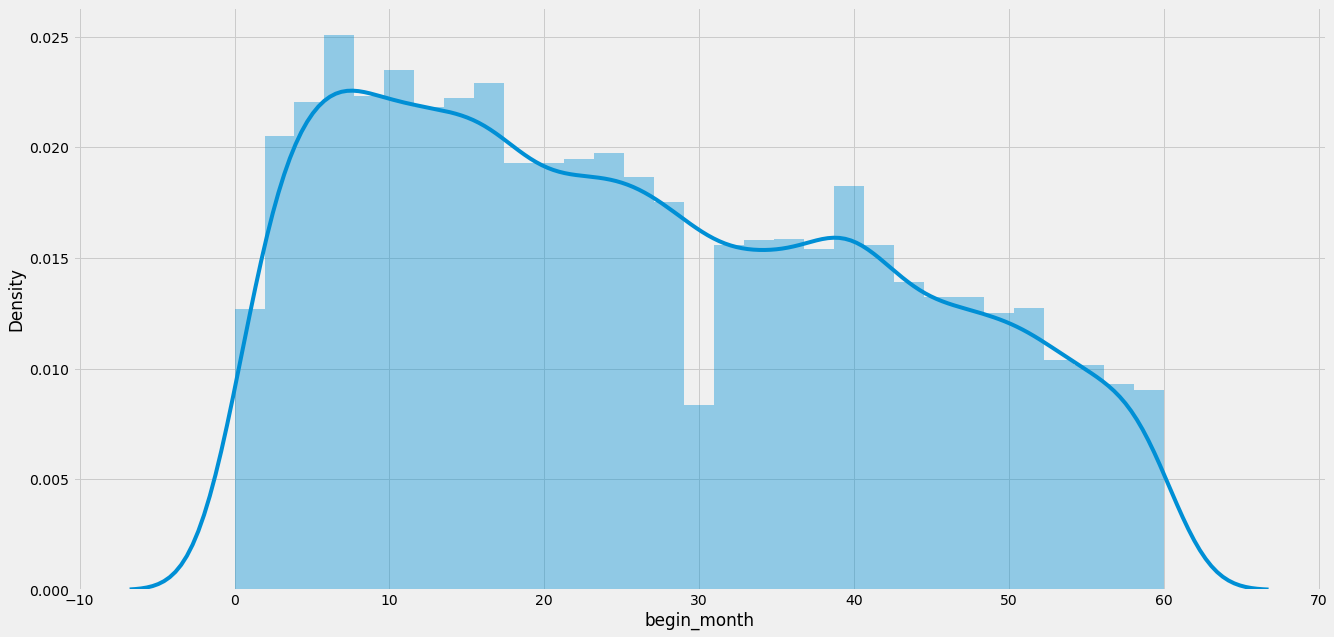

In [22]:
f, ax = plt.subplots(figsize=(20, 10))
sns.distplot(train['begin_month'])

## occyp_type 결측값 처리

+ occyp_type(직업유형)

In [23]:
train.isnull().sum()

index                   0
gender                  0
car                     0
reality                 0
child_num               0
income_total            0
income_type             0
edu_type                0
family_type             0
house_type              0
DAYS_BIRTH              0
DAYS_EMPLOYED           0
FLAG_MOBIL              0
work_phone              0
phone                   0
email                   0
occyp_type           6549
family_size             0
begin_month             0
credit                  0
ability                 0
before_EMPLOYED         0
DAYS_EMPLOYED_log       0
income_total_dev        0
income_total_log        0
dtype: int64

+ occyp_type은 결측값이 6549개

In [24]:
# occyp_type에 있는 결측치를 'DoNotKnow'값으로 대체
train['occyp_type'] = train['occyp_type'].fillna('DoNotKnow')
test['occyp_type'] = test['occyp_type'].fillna('DoNotKnow')

In [25]:
count = 0
category = []
for i in train:
    if train[i].dtype == 'object':
        count += 1
        category.append(i)

In [26]:
for j, cat in enumerate(category):
    for k in train[cat].unique():
        print(f'{k} in {cat}')
        print(train.groupby(by=[cat,'credit'])['index'].count()[k]/train[cat].value_counts()[k])
        print('-'*30)
    print('='*40)

F in gender
credit
0.0    0.121212
1.0    0.237268
2.0    0.641520
Name: index, dtype: float64
------------------------------
M in gender
credit
0.0    0.123002
1.0    0.236016
2.0    0.640982
Name: index, dtype: float64
------------------------------
N in car
credit
0.0    0.120940
1.0    0.242337
2.0    0.636723
Name: index, dtype: float64
------------------------------
Y in car
credit
0.0    0.123223
1.0    0.227862
2.0    0.648915
Name: index, dtype: float64
------------------------------
Y in reality
credit
0.0    0.120736
1.0    0.243016
2.0    0.636249
Name: index, dtype: float64
------------------------------
N in reality
credit
0.0    0.124006
1.0    0.224165
2.0    0.651828
Name: index, dtype: float64
------------------------------
Pensioner in income_type
credit
0.0    0.119718
1.0    0.247324
2.0    0.632958
Name: index, dtype: float64
------------------------------
State servant in income_type
credit
0.0    0.124267
1.0    0.223916
2.0    0.651817
Name: index, dtype: float

In [27]:
# 경력이 없고 occyp_type(직업유형)이 DoNotKnow인 사람은 No_Type_Of_Work로 대체
train.loc[(train['DAYS_EMPLOYED'] == 0) & (train['occyp_type'] == 'DoNotKnow'), 'occyp_type'] = 'No_Type_Of_Work'
test.loc[(test['DAYS_EMPLOYED'] == 0) & (test['occyp_type'] == 'DoNotKnow'), 'occyp_type'] = 'No_Type_Of_Work'

In [28]:
train['occyp_type'].value_counts()

Laborers                 3629
No_Type_Of_Work          3544
DoNotKnow                3005
Core staff               2121
Sales staff              2021
Managers                 1718
Drivers                  1247
High skill tech staff     828
Accountants               742
Medicine staff            684
Cooking staff             378
Security staff            329
Cleaning staff            320
Private service staff     184
Waiters/barmen staff      106
Low-skill Laborers         98
Secretaries                78
Realty agents              53
HR staff                   51
IT staff                   29
Name: occyp_type, dtype: int64

## family_size & child_num

+ family_size(가족규모)
+ child_num(자녀 수)

In [29]:
train['family_size'].value_counts()

2.0     11280
1.0      4123
3.0      3717
4.0      1781
5.0       221
6.0        30
7.0         7
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [30]:
train['child_num'].value_counts()

0     14699
1      4331
2      1853
3       237
4        31
5         8
14        3
7         2
19        1
Name: child_num, dtype: int64

### outlier 처리

In [31]:
# family_size는 최대 6이 되도록 전처리
train.loc[train['family_size'] >= 6,'child_num'] = 6
test.loc[test['family_size'] >= 6,'child_num'] = 6

# chid_num은 최대 4가 되도록 전처리
train.loc[train['child_num'] >= 4,'child_num'] = 4
test.loc[test['child_num'] >= 4,'child_num'] = 4

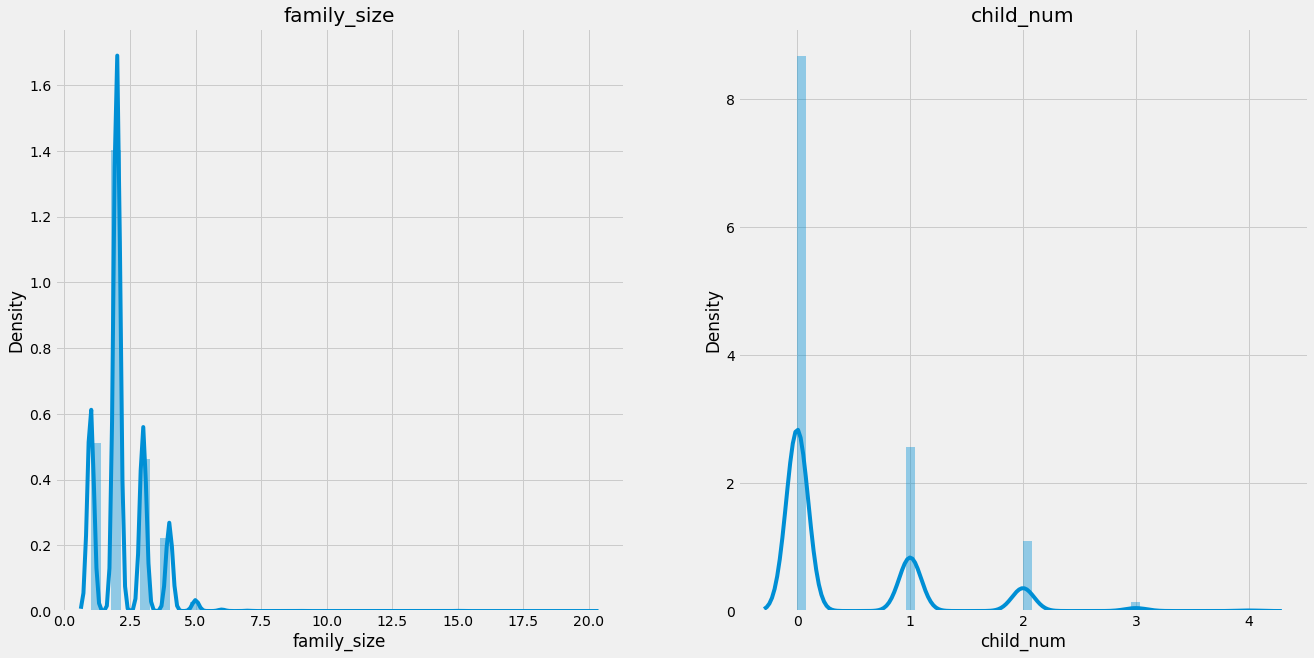

In [32]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.distplot(train['family_size'],ax=ax[0])
ax[0].set_title('family_size')

sns.distplot(train['child_num'],ax=ax[1])
ax[1].set_title('child_num')
plt.show()

## 파생변수(가족수+자녀수)

In [33]:
# 가족수와 자녀수 sum 변수 추가
train['FAM_CHILD_SUM'] = train[['child_num', 'family_size']].sum(axis=1)
test['FAM_CHILD_SUM'] = test[['child_num', 'family_size']].sum(axis=1)

<AxesSubplot:xlabel='FAM_CHILD_SUM', ylabel='Density'>

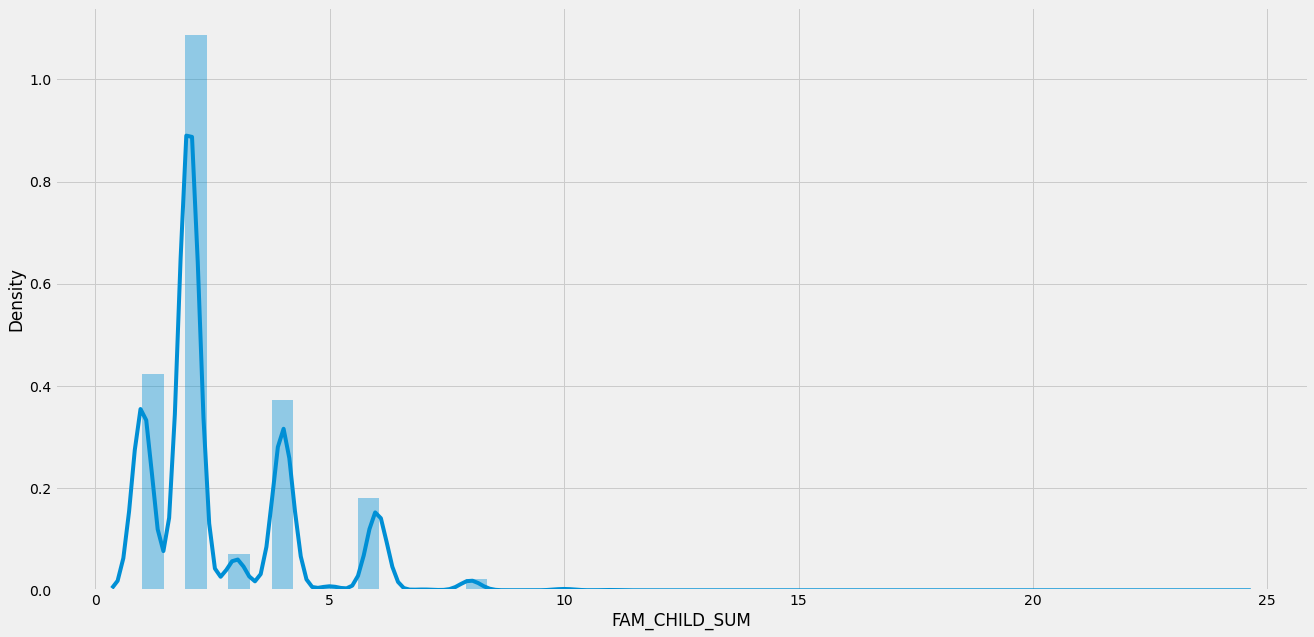

In [34]:
f, ax = plt.subplots(figsize=(20, 10))
sns.distplot(train['FAM_CHILD_SUM'])

## 파생변수(income을 가족 수로 나눈 비율)

In [35]:
# income을 가족 수로 나눈 비율
train['INCOME/FAMILY(RATIO)'] = train['income_total']/train['family_size']
test['INCOME/FAMILY(RATIO)'] = test['income_total']/test['family_size']

<AxesSubplot:xlabel='INCOME/FAMILY(RATIO)', ylabel='Density'>

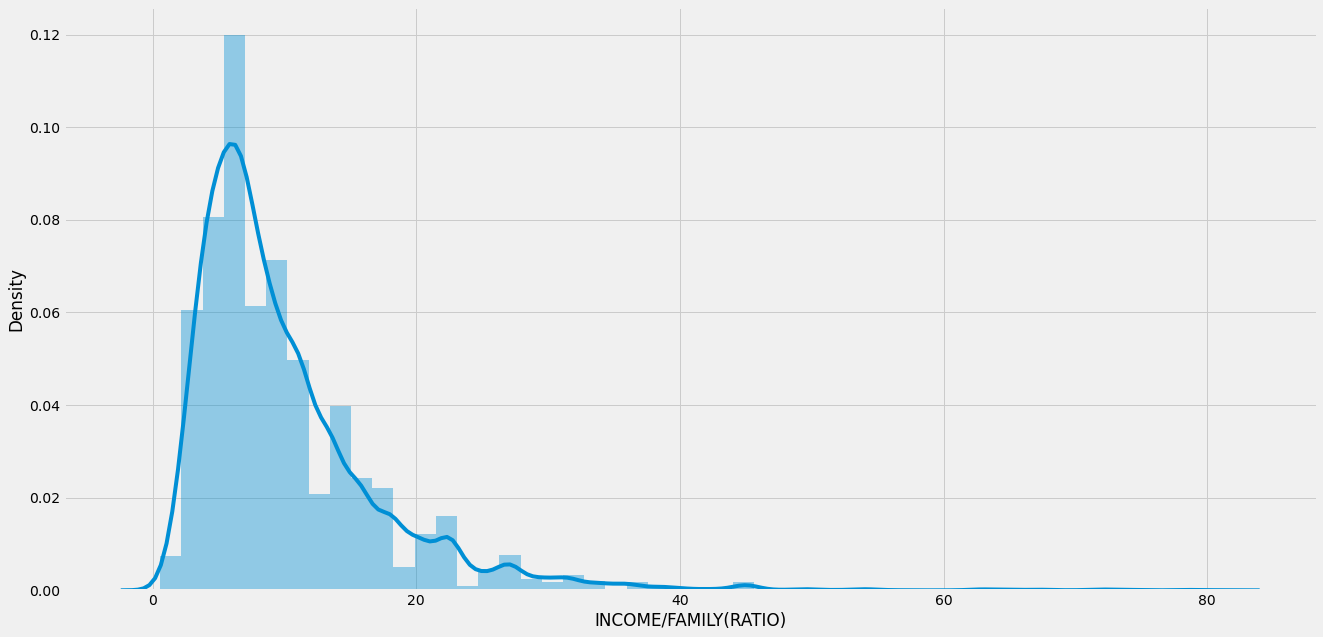

In [36]:
f, ax = plt.subplots(figsize=(20, 10))
sns.distplot(train['INCOME/FAMILY(RATIO)'])

# 필요없는 변수 제거하기

In [37]:
train = train.drop(['index','FLAG_MOBIL','income_total','DAYS_EMPLOYED','family_size','child_num'], axis=1)
test = test.drop(['index','FLAG_MOBIL','income_total','DAYS_EMPLOYED','family_size','child_num'], axis=1)

In [38]:
train_x = train.drop(['credit'],axis=1)
train_y = train['credit']
test_x=test

#  Label Encoding

In [39]:
categorical = train.select_dtypes(object).columns
categorical

Index(['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type',
       'house_type', 'occyp_type'],
      dtype='object')

In [40]:
label = preprocessing.LabelEncoder()
train_processed = pd.DataFrame() 
test_processed = pd.DataFrame() 

for i in train.columns :
    if i in categorical :
        train_processed[i]=label.fit_transform(train[i])
        test_processed[i]=label.fit_transform(test[i])
    elif i == 'credit' :
        train_processed[i]=train[i]
    else :
        train_processed[i]=train[i]
        test_processed[i]=test[i]

# classifier 설정

In [41]:
train_processed_x = train_processed.drop(['credit'],axis=1)
train_processed_y = train_processed['credit']
test_processed_x = test_processed

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [43]:
classifiers = {
    "LogisticRegression" : LogisticRegression(),
    "KNeighbors" : KNeighborsClassifier(),
    "SVC" : SVC(),
    "DecisionTree" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(),
    "XGBoost" : XGBClassifier(),
}

In [44]:
X_train, X_valid, y_train, y_valid = train_test_split(train_processed_x, train_processed_y, test_size=0.2,random_state=49)

In [45]:
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    y_pred=classifier.predict(X_valid)
    print(key)
    print(accuracy_score(y_valid, y_pred))
    print()

LogisticRegression
0.6484762579730687

KNeighbors
0.6135128750295299

SVC
0.6484762579730687

DecisionTree
0.6111504842901015

RandomForest
0.6985589416489487

XGBoost
0.7065910701630049



+ XGBoost가 accuracy가 가장 높게 나옴
+ **XGBOOST로 하자!**

# parameter 설정

## wandb코드(Colab 사용)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/인사이콘 2/데이터전처리데이터_train.csv', index_col=0)
test = pd.read_csv('/content/drive/MyDrive/인사이콘 2/데이터전처리데이터_test.csv', index_col=0)
submission = pd.read_csv('/content/drive/MyDrive/인사이콘 2/submission_sample.csv')

In [ ]:
X = train.drop(['familiy+child', 'credit'], axis=1)
Y = train['credit']

In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

In [ ]:
sweep_config = {
    "method": "random", # try grid or random
    "metric": {
      "name": "accuracy",
      "goal": "maximize"   
    },
    "parameters": {
        "objective": {
            "values": ['multi:softmax']
        },
        "n_estimator": {
            "values": [50, 75, 100, 200, 300, 500, 1000]
        },
        "max_depth": {
            "values": [16, 18, 20, 22, 24, 26]
        },
        "learning_rate": {
            "values": [0.03, 0.05, 0.07, 0.1]
        },
        "subsample": {
            "values": [1, 0.5, 0.3]
        },
        "gamma": {
            "values": [0, 1, 2, 3]
        },
        "min_child_weight":{
            "values": [1, 3, 5]
        },
        "colsample_bytree":{
            "values": [0.5, 0.75, 1]
        },
        "colsample_bylevel":{
            "values": [0.5, 0.75, 1]
        },
        "lambda":{
            "values": [0.5, 1, 1.5, 2]
        }

    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="XGBoost-sweeps")

In [ ]:
# XGBoost model for Pima Indians dataset
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load data
def train():
  config_defaults = {
    "booster": "gbtree",
    "max_depth": 3,
    "learning_rate": 0.1,
    "subsample": 1,
    "seed": 117,
    "test_size": 0.33,
  }

  wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
  config = wandb.config

  # load data and split into predictors and targets
  #dataset = loadtxt("pima-indians-diabetes.data.csv", delimiter=",")
  #X, Y = dataset[:, :8], dataset[:, 8]

  # split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                      test_size=config.test_size,
                                                      random_state=config.seed)

  # fit model on train
  model = XGBClassifier(booster=config.booster, max_depth=config.max_depth,
                        learning_rate=config.learning_rate, subsample=config.subsample)
  model.fit(X_train, y_train)

  # make predictions on test
  y_pred = model.predict(X_test)
  predictions = [round(value) for value in y_pred]

  # evaluate predictions
  accuracy = accuracy_score(y_test, predictions)
  print(f"Accuracy: {int(accuracy * 100.)}%")
  wandb.log({"accuracy": accuracy})

In [ ]:
wandb.agent(sweep_id, train, count=50)

In [ ]:
sweep_config = {
    "method": "random", # try grid or random
    "metric": {
      "name": "accuracy",
      "goal": "maximize"   
    },
    "parameters": {
        "learning_rate": {
            "values": [0.05, 0.07]
        },
        "subsample": {
            "values": [0.7, 0.5, 0.3, 0.2]
        },
        "gamma": {
            "values": [0, 0.5, 1, 2]
        },
        "colsample_bytree":{
            "values": [0.5, 0.75, 1]
        },
        "lambda":{
            "values": [0.5, 1, 1.5, 2]
        },
        "sclae_pos_weight":{
            "values": [0.15, 0.3, 0.5, 0.7]
        }

    }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="XGBoost-sweeps")

In [ ]:
# XGBoost model for Pima Indians dataset
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# load data
def train():
  config_defaults = {
    "n_estimator": 200,
    "objective": 'multi:softmax',
    "booster": "gbtree",
    "max_depth": 16,
    "learning_rate": 0.1,
    "subsample": 1,
    "seed": 117,
    "test_size": 0.33,
  }

  wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
  config = wandb.config

  # load data and split into predictors and targets
  #dataset = loadtxt("pima-indians-diabetes.data.csv", delimiter=",")
  #X, Y = dataset[:, :8], dataset[:, 8]

  # split data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                      test_size=config.test_size,
                                                      random_state=config.seed)

  # fit model on train
  model = XGBClassifier(booster=config.booster, max_depth=config.max_depth,
                        learning_rate=config.learning_rate, subsample=config.subsample)
  model.fit(X_train, y_train)

  # make predictions on test
  y_pred = model.predict(X_test)
  predictions = [round(value) for value in y_pred]

  # evaluate predictions
  accuracy = accuracy_score(y_test, predictions)
  print(f"Accuracy: {int(accuracy * 100.)}%")
  wandb.log({"accuracy": accuracy})

In [ ]:
wandb.agent(sweep_id, train, count=50)

## wandb 결과값

+ hyperparameter 여러 번 실험한 것 중 하나의 예시
+ accuracy가 가장 높게 나온 parameter 조합들 중 하나 선택!

![nn](사진1.png)

![nn](사진2.png)

In [46]:
xgb1 = XGBClassifier(
        booster='gbtree',
        learning_rate =0.05,
        n_estimators=1000,
        max_depth=6,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'multi:softmax',
        seed=5,
    )
xgb1.fit(X_train, y_train)
y_pred = xgb1.predict(X_valid)
accuracy=accuracy_score(y_valid, y_pred)
accuracy

0.7139144814552327

+ valid set과 비교했을 때의 accuracy값은 0.714가 나옴

In [47]:
# 데이터 전처리한 전체 train값을 이용해 credit값 예측
xgb1.fit(train_processed_x, train_processed_y)
y_pred = xgb1.predict(test_processed_x)

# Make Submission File

In [48]:
submission.loc[:,1:] = y_pred
submission

,index,credit
0,24516,2
1,22181,2
2,19366,1
3,19847,2
4,1617,2
...,...,...
5287,4013,2
5288,19775,2
5289,6451,2
5290,17778,2


In [49]:
submission.to_csv('submission_6조_찐찐찐찐최종.csv')

# 감사합니다😊❤️‍